## Set up Enviroment by enabling the current workspace venv

In [58]:
!pip freeze

asttokens==3.0.0
colorama==0.4.6
comm==0.2.2
contourpy==1.3.1
cycler==0.12.1
debugpy==1.8.12
decorator==5.2.1
executing==2.2.0
fonttools==4.56.0
ipykernel==6.29.5
ipython==8.32.0
jedi==0.19.2
jupyter_client==8.6.3
jupyter_core==5.7.2
kiwisolver==1.4.8
matplotlib==3.10.0
matplotlib-inline==0.1.7
nest-asyncio==1.6.0
numpy==2.2.3
packaging==24.2
pandas==2.2.3
parso==0.8.4
pillow==11.1.0
platformdirs==4.3.6
prompt_toolkit==3.0.50
psutil==7.0.0
pure_eval==0.2.3
Pygments==2.19.1
pyparsing==3.2.1
python-dateutil==2.9.0.post0
pytz==2025.1
pywin32==308
pyzmq==26.2.1
scipy==1.15.2
six==1.17.0
stack-data==0.6.3
tornado==6.4.2
tqdm==4.67.1
traitlets==5.14.3
tzdata==2025.1
wcwidth==0.2.13


In [59]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install tqdm
!pip install scipy

## Initialize some values
Here is how we are going to set this up, the entire map will be from {0<=x<=1} {0<=y<=1} 
The heruistic map will be split using the mapResolution variable to then split this 1x1 grid into sections to then generate a aproximated heruistic

In [233]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from tqdm import tqdm

#Heuristic map
mapResolution = 32
heuristicMap = np.zeros((mapResolution, mapResolution))

#Start and Goal
start = (0, 0)
goal = (1, 1)

## Set up some Functions

In [234]:
#corodinates to heuristic map index *not sure if this is needed
def coord2ind(x, y):
    if x > 1 or x < 0 or y > 1 or y < 0:
        print(f"Error: x and y must be within the range [0, 1]")
        raise ValueError
    return (round(x*mapResolution) , round(y*mapResolution))

#heuristic map index to coordinate within that cell, random uniform distribution within cell
def ind2coord(x, y):
    #x and y cannot be larger or equal to mapResolution
    if x >= mapResolution or y >= mapResolution:
        print(f"Error: x and y cannot be larger or equal to mapResolution: {mapResolution}")
        raise ValueError
    return (np.random.uniform(x/mapResolution, (x+1)/mapResolution), np.random.uniform(y/mapResolution, (y+1)/mapResolution))

#heuristic function
def euclidean_distance_heuristic(x, y):
    return np.sqrt((x-goal[0])**2 + (y-goal[1])**2)

## Initialize heuristic

In [241]:
#fill heuristic map
for i in tqdm(range(mapResolution)):
    for j in range(mapResolution):
        heuristicMap[i, j] = euclidean_distance_heuristic(i/mapResolution, j/mapResolution)

100%|██████████| 32/32 [00:00<00:00, 33970.57it/s]


## Plot the current situation

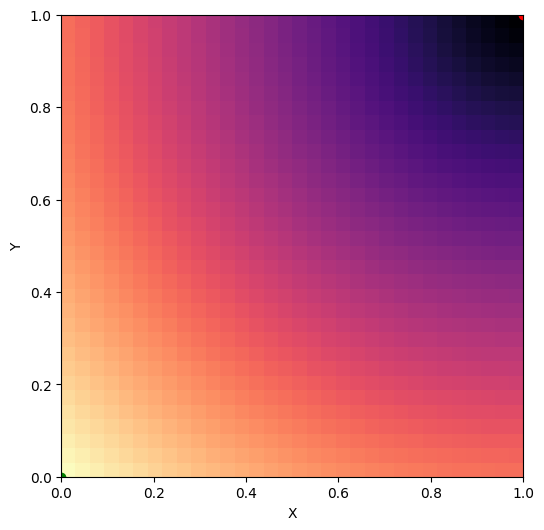

In [219]:
plt.figure(figsize=(6, 6))
plt.plot(start[0], start[1], 'go', label='Start')  # green dot for start
plt.plot(goal[0], goal[1], 'ro', label='Goal')    # red dot for goal
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')

#overlay heuristic map
plt.imshow(heuristicMap, cmap='magma', interpolation='nearest', extent=[0, 1, 0, 1], origin='lower')
plt.show()